Mounting google drive to access the training and validation data sets.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

folder_path = '/content/drive/MyDrive/CFD Training'
os.listdir(folder_path)


['.DS_Store',
 'Natalie Portman',
 'Tom Hanks',
 'Megan Fox',
 'Denzel Washington',
 'Nicole Kidman',
 'Kate Winslet',
 'Johnny Depp',
 'Sandra Bullock',
 'Will Smith',
 'Scarlett Johansson',
 'Brad Pitt',
 'Robert Downey Jr',
 'Jennifer Lawrence',
 'Leonardo DiCaprio',
 'Angelina Jolie',
 'Hugh Jackman',
 'Tom Cruise']

Checking contents (folders) in the training file.

In [4]:
for item in os.listdir(folder_path):
    item_path = os.path.join(folder_path, item)
    if os.path.isfile(item_path):
        print(f"File: {item} - Size: {os.path.getsize(item_path)} bytes")
    elif os.path.isdir(item_path):
        print(f"Folder: {item}")


File: .DS_Store - Size: 14340 bytes
Folder: Natalie Portman
Folder: Tom Hanks
Folder: Megan Fox
Folder: Denzel Washington
Folder: Nicole Kidman
Folder: Kate Winslet
Folder: Johnny Depp
Folder: Sandra Bullock
Folder: Will Smith
Folder: Scarlett Johansson
Folder: Brad Pitt
Folder: Robert Downey Jr
Folder: Jennifer Lawrence
Folder: Leonardo DiCaprio
Folder: Angelina Jolie
Folder: Hugh Jackman
Folder: Tom Cruise


Checking the contents of each of the folders inside the training dataset and the number of images in each folder of the actor and actress.

In [5]:
main_folder_path = '/content/drive/MyDrive/CFD Training'
subfolders = [f.path for f in os.scandir(main_folder_path) if f.is_dir()]

for subfolder in subfolders:
    print("Processing subfolder:", subfolder)
    num_images = len(os.listdir(subfolder))
    print("Number of images:", num_images)


Processing subfolder: /content/drive/MyDrive/CFD Training/Natalie Portman
Number of images: 81
Processing subfolder: /content/drive/MyDrive/CFD Training/Tom Hanks
Number of images: 81
Processing subfolder: /content/drive/MyDrive/CFD Training/Megan Fox
Number of images: 81
Processing subfolder: /content/drive/MyDrive/CFD Training/Denzel Washington
Number of images: 81
Processing subfolder: /content/drive/MyDrive/CFD Training/Nicole Kidman
Number of images: 81
Processing subfolder: /content/drive/MyDrive/CFD Training/Kate Winslet
Number of images: 91
Processing subfolder: /content/drive/MyDrive/CFD Training/Johnny Depp
Number of images: 81
Processing subfolder: /content/drive/MyDrive/CFD Training/Sandra Bullock
Number of images: 81
Processing subfolder: /content/drive/MyDrive/CFD Training/Will Smith
Number of images: 81
Processing subfolder: /content/drive/MyDrive/CFD Training/Scarlett Johansson
Number of images: 181
Processing subfolder: /content/drive/MyDrive/CFD Training/Brad Pitt
Num

Training a model to analyze the images in the folders, printing the accuracy of the model. The model has been augmented using specific dimensions for portraits as most of the images of the celebrities are portrait images. I tried increasing the epochs and decreasing them as well, when I decrease the numebr of epochs (to 10 epochs), the accuracy is too low. When I increase the number of epochs (to 100 epochs), the accuracy is higher numerically but the graph is very scattered and the  model keeps classifying new images (not part of the training or validation datasets) into one single class only.

In [6]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
import math
# Define the learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

# Image data generator for training data with specific augmentations for portraits
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=(0.9, 1.1),
    zoom_range=[0.9, 1.1],
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/CFD Training',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Image data generator for validation data
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    '/content/drive/MyDrive/CFD Validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

# Model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    BatchNormalization(),
    Dense(17, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)  # Adjusted learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
lrate_schedule = LearningRateScheduler(step_decay)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)


# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs= 50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[lrate_schedule]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(validation_generator)
print("Test Accuracy:", test_accuracy)


Found 1470 images belonging to 17 classes.
Found 350 images belonging to 17 classes.
Epoch 1/50
46/46 [==============================] - 423s 9s/step - loss: 2.9729 - accuracy: 0.1143 - val_loss: 2.8588 - val_accuracy: 0.0743 - lr: 0.0010
Epoch 2/50
46/46 [==============================] - 116s 3s/step - loss: 2.6329 - accuracy: 0.1673 - val_loss: 2.9575 - val_accuracy: 0.0743 - lr: 0.0010
Epoch 3/50
46/46 [==============================] - 111s 2s/step - loss: 2.3917 - accuracy: 0.2381 - val_loss: 2.9587 - val_accuracy: 0.0743 - lr: 0.0010
Epoch 4/50
46/46 [==============================] - 110s 2s/step - loss: 2.4414 - accuracy: 0.2041 - val_loss: 3.0883 - val_accuracy: 0.0743 - lr: 0.0010
Epoch 5/50
46/46 [==============================] - 109s 2s/step - loss: 2.4259 - accuracy: 0.2293 - val_loss: 2.7679 - val_accuracy: 0.0857 - lr: 0.0010
Epoch 6/50
46/46 [==============================] - 122s 3s/step - loss: 2.3932 - accuracy: 0.2109 - val_loss: 2.8367 - val_accuracy: 0.0829 - lr

I plotted the loss and accuracy graphs using the code below.

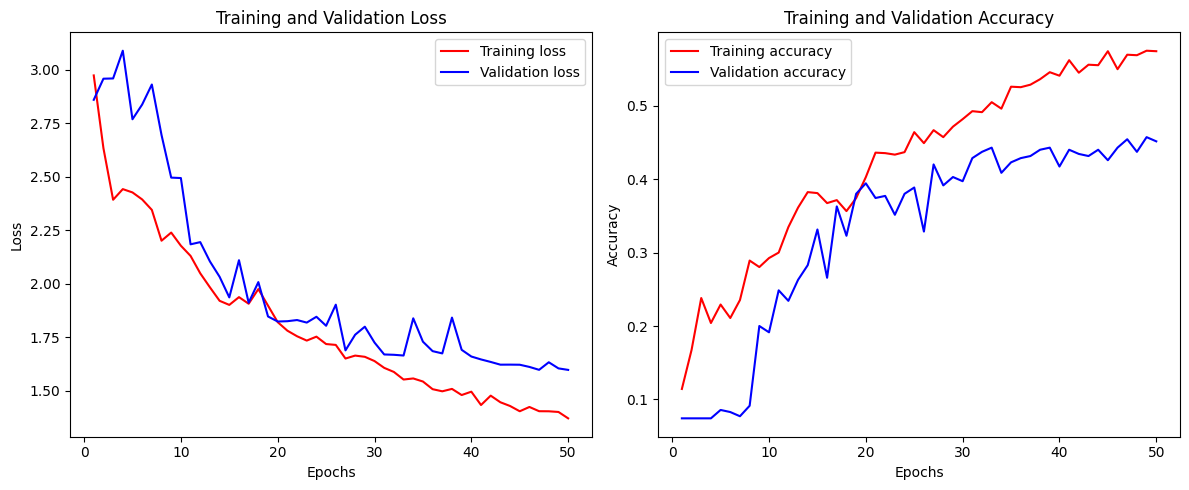

In [7]:
import matplotlib.pyplot as plt

# Retrieve history of training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

# Retrieve history of training and validation accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

# Plot the loss over each epoch
plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'r-', label='Training loss')  # Red solid line
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'r-', label='Training accuracy')  # Red solid line
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
  # Test 1 (Correct)

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the new image
img_path = '/content/rdj test.jpeg'  # Replace with the path to your new image
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Get the model's prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Map predicted class index to class label
class_labels = train_generator.class_indices  # Assuming train_generator is your training data generator
predicted_label = [k for k, v in class_labels.items() if v == predicted_class][0]

print("Predicted class:", predicted_label)

1/1 [==============================] - 0s 380ms/step
Predicted class: Robert Downey Jr


In [ ]:
# Test 2 (Correct)

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the new image
img_path = '/content/JD test.jpeg'  # Replace with the path to your new image
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Get the model's prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Map predicted class index to class label
class_labels = train_generator.class_indices  # Assuming train_generator is your training data generator
predicted_label = [k for k, v in class_labels.items() if v == predicted_class][0]

print("Predicted class:", predicted_label)

1/1 [==============================] - 0s 44ms/step
Predicted class: Johnny Depp


In [ ]:
# Test 3 (Correct)

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the new image
img_path = '/content/NicoleKidman test.jpeg'  # Replace with the path to your new image
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Get the model's prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Map predicted class index to class label
class_labels = train_generator.class_indices  # Assuming train_generator is your training data generator
predicted_label = [k for k, v in class_labels.items() if v == predicted_class][0]

print("Predicted class:", predicted_label)

1/1 [==============================] - 0s 41ms/step
Predicted class: Nicole Kidman


In [ ]:
# Test 4 (Correct)

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the new image
img_path = '/content/ScarJo test.jpeg'  # Replace with the path to your new image
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Get the model's prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Map predicted class index to class label
class_labels = train_generator.class_indices  # Assuming train_generator is your training data generator
predicted_label = [k for k, v in class_labels.items() if v == predicted_class][0]

print("Predicted class:", predicted_label)

1/1 [==============================] - 0s 44ms/step
Predicted class: Scarlett Johansson


In [ ]:
# Test 5 (Correct)

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the new image
img_path = '/content/WillSmith tes.jpeg'  # Replace with the path to your new image
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Get the model's prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Map predicted class index to class label
class_labels = train_generator.class_indices  # Assuming train_generator is your training data generator
predicted_label = [k for k, v in class_labels.items() if v == predicted_class][0]

print("Predicted class:", predicted_label)

1/1 [==============================] - 0s 113ms/step
Predicted class: Will Smith


In [ ]:
# Test 6 (Fail)

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the new image
img_path = '/content/TomCruise test2.jpeg'  # Replace with the path to your new image
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.

# Get the model's prediction
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction)

# Map predicted class index to class label
class_labels = train_generator.class_indices  # Assuming train_generator is your training data generator
predicted_label = [k for k, v in class_labels.items() if v == predicted_class][0]

print("Predicted class:", predicted_label)

1/1 [==============================] - 0s 43ms/step
Predicted class: Hugh Jackman


# Final remarks:
Accuracy of the model is not that high, the model is working. The model could classify 5 of the 6 celebrities correctly but made one mistake (Last test, classifying a picture of Tom Cruise as Hugh Jackman). The loss and accuracy graphs also indicate that while the model is not the best, the accuracy kept increasing and loss kept decreasing per epoch for both validation and training data.